In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import ast
from itertools import zip_longest

import warnings
warnings.filterwarnings('ignore')

In [86]:
target = "Lehne"
# target = "Delatorre"

In [87]:
def get_zipped_average(lists):
    zipped_lists = zip_longest(*lists, fillvalue=None)
    averages = [
        sum(filter(None.__ne__, group)) / max(1, len(list(filter(None.__ne__, group))))
        for group in zipped_lists
    ]
    return averages

def get_llm_ratings(llm_rating_sources: list[str]) -> list[float]:
    """
    Get the average llm rating for a given source.
    Args:
        llm_rating_sources: list of llm rating sources. This is the dirname to start checking for csv files from.
                            Subdirectories will be checked starting from this directory.
    Return:
        List of all llm ratings for the given source.
        If multiple sources are given return the average rating across all sources.
    """
    all_source_ratings = []

    for source in llm_rating_sources:
        source = f"{os.path.dirname(os.path.abspath(os.getcwd()))}/../outputs/{source}"
        source_ratings = []
        
        # Traverse through the directory to find CSV files
        for root, _, files in os.walk(source):
            for file in files:
                if file.endswith(".csv"):
                    # Read the CSV file
                    file_path = os.path.join(root, file)
                    df = pd.read_csv(file_path)
                    
                    # Assuming the response column contains the dictionary of ratings as string
                    if 'response' in df.columns:
                        model_ratings = []
                        for response in df['response']:
                            response_dict = ast.literal_eval(response)
                            ratings = response_dict.values()
                            model_ratings.append(ratings)
                        source_ratings = get_zipped_average(model_ratings)
        
        if source_ratings:
            all_source_ratings.append(source_ratings)

    llm_ratings = get_zipped_average(all_source_ratings)
    return llm_ratings

def per_model_ratings(llm_rating_sources: list[str]) -> dict[str, list[float]]:
    """
    Get the llm ratings from all sources.
    Args:
        llm_rating_sources: list of llm rating sources. This is the dirname to start checking for csv files from.
                            Subdirectories will be checked starting from this directory.
    Return:
        Dict of all llm ratings from all sources.
        Keyed by model name to list of scores.
    """
    all_ratings = {}

    experiments = ["e1", "e2", "e3"]
    model_names = ['deepseek-ai_DeepSeek-V3', 'google_gemma-2-27b-it', 'google_gemma-2-9b-it', 'meta-llama_Llama-2-7b-chat-hf', 'meta-llama_Llama-3-70b-chat-hf', 'meta-llama_Llama-3-8b-chat-hf', 'microsoft_WizardLM-2-8x22B', 'mistralai_Mistral-7B-Instruct-v0.3', 'mistralai_Mixtral-8x7B-Instruct-v0.1', 'Qwen_Qwen2-72B-Instruct']
    shortened_model_names = ["DS-V3", "G-27B", "G-9B", 'L2-7B', 'L3-70B', 'L3-8B', 'W-22B', 'M-7B', 'Mx-7B', 'Q-72B']

    for source in llm_rating_sources:
        source = f"{os.path.dirname(os.path.abspath(os.getcwd()))}/../outputs/{source}"

        for experiment in experiments:
            for i, model in enumerate(model_names):
                csv_path = os.path.join(source, experiment, model)
                csv_path = os.path.join(csv_path, os.listdir(csv_path)[0], "results.csv")

                # Read the CSV file
                ratings = []
                df = pd.read_csv(csv_path)
                if 'response' in df.columns:
                    for response in df['response']:
                        response_dict = ast.literal_eval(response)
                        ratings = list(response_dict.values())

                shortened_model_name = shortened_model_names[i]
                if shortened_model_name not in all_ratings:
                    all_ratings[shortened_model_name] = []
                all_ratings[shortened_model_name].append(ratings)

    for shortened_model_name, ratings in all_ratings.items():
        all_ratings[shortened_model_name] = get_zipped_average(ratings)

    return all_ratings


In [88]:
llm_rating_sources = None
if target == "Lehne":
    llm_rating_sources = ["lehne_experiment/final/"]
elif target == "Delatorre":
    llm_rating_sources = ["delatorre_experiment/final/"]

llm_ratings = get_llm_ratings(llm_rating_sources)
llm_ratings_by_model = per_model_ratings(llm_rating_sources)

In [89]:
lehne = [5.565217391, 5, 4.826086957, 5.739130435, 5.52173913, 6.826086957, 7.304347826, 5.434782609, 6.391304348, 7.47826087, 7.043478261, 5.869565217, 6.739130435, 6.956521739, 6.47826087, 5.956521739, 4.652173913, 4.260869565, 5.173913043, 4.086956522, 4.173913043, 4.304347826, 5, 4.043478261, 4.217391304, 4.434782609, 5.347826087, 6.217391304, 5.434782609, 4.782608696, 6.173913043, 5.956521739, 6.47826087, 5, 4.739130435, 5.173913043, 6.304347826, 6.434782609, 5.260869565, 5.304347826, 5.956521739, 4.304347826, 5.260869565, 4.391304348, 4.956521739, 5.695652174, 5.043478261, 5.826086957, 5.043478261, 4.913043478, 5.217391304, 6.217391304, 6.391304348, 6.52173913, 7.217391304, 6.565217391, 5.52173913, 4.347826087, 3.869565217, 7, 7.565217391, 6.52173913, 6.260869565, 6.043478261, 4.913043478]

# bentz = [5.722806985294119, 11.05916240409207, 10.176644957983195, 7.114928792569659, 6.099157439446366, 5.566299307958478, 17.45514241486068, 20.56654953560372, 14.074101604278075, 11.005892857142857, 10.182784926470589, 13.225643598615918, 15.510902476780188, 17.722190311418682, 17.559285294117643, 16.105406862745095, 14.799439705882353, 13.646433006535949, 13.32528431372549, 17.817691950464397, 19.465673010380623, 19.729349845201238, 17.95638080495356, 16.52333281733746, 15.829901960784314, 14.44470751633987, 11.858982352941178, 12.473614705882353, 13.266633126934982, 12.13799705882353, 11.304029411764708, 10.899100346020763, 11.029245098039217, 12.146807189542484, 12.750317647058825, 12.54380735294118, 13.642642647058825, 14.732547058823531, 16.67970261437908, 15.694006047873696, 15.648868512110726, 15.350144117647059, 15.374905882352943, 14.648437908496735, 12.62051797385621, 10.956928104575162, 9.631577030812325, 9.692333910034604, 8.245710784313728, 9.478299051857585, 12.43716563467492, 12.374813725490196, 12.402410130718955, 14.686942810457518, 15.052090073529412, 14.634486068111453, 18.123255882352943, 19.497089783281734, 19.749135294117647, 20.792210784313724, 21.082425696594427, 19.15788235294118, 18.07518137254902, 18.323945187165776, 19.19976989619377, 16.961331699346406, 14.677286377708977, 13.684705882352944, 15.826565015479877, 19.672383986928104, 21.969750865051907, 23.30329411764706, 24.561427601809957, 24.233156346749222, 24.545139705882352, 26.391583591331266, 26.473653594771243, 25.7525, 28.182441176470586, 30.907944444444443, 31.042676470588233, 29.05366666666667, 27.47116176470588, 26.843221227621484, 25.45178947368421, 24.945612299465243, 26.672071428571428, 26.546444272445818, 24.512742647058825, 24.267127450980393, 27.192478991596637, 33.16186425339367, 32.094166666666666, 29.6981, 28.632405462184874, 27.773249999999997, 26.992778546712803, 24.78235294117647, 23.85904411764706, 23.71569040247678, 24.106462848297216, 22.55586061381074, 22.374941176470585, 21.841009803921565, 20.480698529411768, 17.6074446366782, 14.44325541795666, 12.524396284829722, 11.880472549019608, 15.512207282913167, 20.616085139318887, 20.464073529411767, 21.093086687306506, 20.856195187165778, 17.839051470588235, 16.535029411764707, 15.656599439775912, 16.932544117647055, 22.179710294117648, 21.456007352941175, 20.117741830065363, 19.28415294117647, 18.910838235294122, 18.918298319327732, 17.779165266106443, 17.466493464052295, 19.231535294117645, 22.93496323529412, 26.49512254901961, 27.205697058823525, 30.007072192513373, 28.393787925696596, 26.85357352941176, 28.249730392156863, 27.244920168067228, 27.338547794117645, 26.54530588235294, 24.899828173374612, 22.83691176470588, 20.77564985994398, 20.51521568627451, 19.062049019607837, 16.592596638655465, 18.275367647058825, 27.905075, 29.334514705882352, 25.093589572192517, 19.447133126934983, 16.447647058823527, 19.058363636363637, 24.388437908496734, 26.278242647058825, 25.534026960784313, 29.21232549019608, 29.795710084033615, 24.86472910216718, 22.863725490196078, 20.7369692513369, 19.076182352941174, 18.517647058823528, 17.6023487394958, 14.94836111111111, 13.438740896358544, 16.105606209150327, 18.319954248366013, 18.078679411764707, 17.664794117647062, 17.06517513368984, 16.485388544891638, 14.427848755441453, 13.576512110726641, 12.017716176470588, 11.879204044117648, 12.809175, 17.503256535947713, 17.75494537815126, 18.65083823529412, 16.02368464052288, 14.073091176470587, 13.904702205882352, 13.971928571428572, 12.923748663101604, 12.225941176470588, 12.662591911764704, 12.602894117647057, 12.4060318627451, 12.417464985994396, 14.151664705882357, 16.339893557422972, 17.893362745098038, 19.200911764705882, 19.12337843137255, 17.371677941176475, 16.607595588235295, 17.630668730650154, 18.307455882352944, 18.467377941176473, 18.9919068627451, 20.069433823529412, 21.336068111455113, 22.731417956656344, 22.903745989304813, 21.71013088235294, 22.42164705882353, 23.16619117647059, 23.875465944272445, 24.320976890756302, 24.03204248366013, 26.109693771626297, 26.222119117647054, 25.410250700280113, 24.074558823529408, 24.078991176470588, 23.25504347826087, 21.991056722689073, 21.338450980392153, 20.9964375, 20.335875, 20.66961764705882, 23.344540106951875, 26.51085294117647, 26.013720588235294, 24.250387543252593, 21.990600840336132, 23.025572829131654, 25.236897058823526, 26.32927124183006, 26.120114186851215, 26.55146323529412, 26.839447058823527, 26.900848739495792, 26.29785294117647, 26.07654411764706, 26.037251633986934, 26.898101604278075, 33.81381833910035, 48.40757266435986, 53.42682843137255, 50.233819852941174, 51.924921568627454, 56.08438235294117, 59.119974789915965, 64.23566099071206, 75.36540896358544, 80.959, 85.98692794117648, 95.3404986631016, 100.96856617647059, 104.29738235294117, 107.63588051470587, 105.21067647058825, 102.231022875817, 103.0474814241486, 101.73784191176472, 102.93723529411764, 109.76126470588235, 105.01897181372549, 100.85559861591695, 98.2981950464396, 95.37922029456944, 88.44012383900929, 91.06242112299464, 97.15785139318886, 101.01073529411764, 100.60330555555554, 100.73289792387541, 96.95793252595156, 95.07487794117648, 94.74019117647059, 90.16191470588237, 80.02010147058823, 73.68095674740485, 67.8421388888889, 62.97488368983957, 61.147489164086686, 58.41641176470589, 56.10203460207612, 56.42993417366946, 54.690753869969036, 51.81656029411764, 55.88604024767801, 60.369505882352954, 63.258568181818184, 65.71950865051903, 69.30895847750865, 70.19432352941178, 68.85285166240409, 64.15298970588236, 60.50676315789474, 58.44099999999999, 57.931379256965954, 57.87941978609624, 57.260163235294115, 57.892364450127864, 64.26010084033614, 75.93474369747899, 79.10853970588235, 79.84661764705884, 80.14906699346403, 78.73512659846547, 80.78884852941178, 82.58434313725489, 77.31641176470586, 74.37791560102302, 69.61072727272726, 68.00538235294118, 68.49562834224598, 64.78805263157895, 65.41110681114553, 69.15733545539427, 71.53683823529411, 74.32562464985995, 75.17658403361345, 73.41823262032086, 70.05329901960782, 68.92875882352942, 65.90874264705883, 64.39923839009286, 64.80960947712418, 65.26220772058822, 65.31959442724458, 63.767246498599434, 63.6881544117647, 63.17291176470589, 63.206561764705896, 64.11639619377162, 66.3888161764706, 68.17158996539793, 66.71792647058822, 67.15861601307189, 69.07404144385026, 70.47444999999999, 75.52585154061623, 80.42727287581698, 83.9655795847751, 90.30962605042016, 96.34309967320263, 98.82436580882356, 98.93075386996904, 105.83735588235295, 117.33584313725491, 115.10439100346024, 110.06833823529412, 109.99914086687306, 112.26201038062285, 113.28615641711234, 119.9344792387543, 130.197075, 138.93484803921567, 160.56501764705882, 175.16024117647058, 177.82488088235294, 173.9028010380623, 172.35485994397757, 173.41732085561495, 174.48921148459382, 174.8938786764706, 177.56210620915033, 179.8769820261438, 186.9069598930481, 190.00573262032086, 187.5332771493213, 190.80463840830453, 191.67416470588233, 187.11683753501399, 184.9210089514066, 188.39724732620323, 191.07466830065357, 185.84813647058826, 185.2796047873695, 184.24081764705883, 178.19064901960786, 171.65868088235297, 166.3054607843137, 156.8334117647059, 149.46710695187167, 141.0820544117647, 132.4475277777778, 133.4323511029412, 137.71560934421615, 136.36293088235294, 132.74120728291317, 129.13788502673793, 128.90934313725492, 129.3448382352941, 124.2884814241486, 124.98641176470588, 127.4297149321267, 132.95456470588235, 143.21540660474716, 151.37776890756302, 157.96819362745103, 165.58177030812325, 181.4628273657289, 189.25946439628478, 190.46434117647058, 176.1628431372549, 150.24279721362228, 132.26847549019607, 121.65475605536331, 110.69548452012384, 100.93981764705885, 93.22973684210525, 86.00066408668731, 80.4442614379085, 75.58584256055366, 67.52603267973858, 61.81637925696595, 61.09287955182073, 61.245064616755805, 61.05702941176471, 61.013605882352934, 63.42195220588236, 64.37568797953965, 66.15234593837535, 67.92524019607843, 67.50347794117648, 68.59144537815125, 69.4542463235294, 69.21378208556149, 71.80952941176471, 67.92987955182072, 61.98466106442578, 52.874304812834225, 42.26799845201239, 43.57794117647059, 39.6671568627451, 39.98655882352941, 42.754394957983195, 49.93342647058824, 49.57645098039216, 45.58964999999999, 48.392751633986926, 50.793138235294116, 52.714708439897684, 52.38061764705883, 51.60355882352942, 50.22640712074303, 49.45389635854341, 52.57689366515837]

delatorre = [3.34, 3.725, 3.705, 3.89, 4.08, 5.02, 4.87, 4.81, 5.84, 5.77, 6.44, 4.685]

In [90]:
human_ratings = None
if target == "Lehne":
    human_ratings = lehne
elif target == "Delatorre":
    human_ratings = delatorre

In [91]:
# plt.plot(llm_ratings, label='LLM Ratings')
# plt.plot(human_ratings, label='Human Ratings')

# plt.title('LLM vs Human Suspense Ratings')
# plt.xlabel('Passage')
# plt.ylabel('Suspense Rating')
# plt.legend()

# plt.show()

In [92]:
# llm_ratings_norm = (np.array(llm_ratings) - np.min(llm_ratings)) / (np.max(llm_ratings) - np.min(llm_ratings))
# human_ratings_norm = (np.array(human_ratings) - np.min(human_ratings)) / (np.max(human_ratings) - np.min(human_ratings))
# plt.plot(llm_ratings_norm, label='LLM Ratings Normalized')
# plt.plot(human_ratings_norm, label='Human Ratings Normalized')

# plt.title('Normalized LLM vs Human Suspense Ratings')
# plt.xlabel('Passage')
# plt.ylabel('Suspense Rating')
# plt.legend()
    
# plt.show()

In [93]:
# llm_ratings_diff = np.diff(llm_ratings)
# human_ratings_diff = np.diff(human_ratings)
# plt.plot(llm_ratings_diff, label='LLM Ratings Diff')
# plt.plot(human_ratings_diff, label='Human Ratings Diff')

# plt.title('LLM vs Human Suspense Ratings Diff')
# plt.xlabel('Passage')
# plt.ylabel('Suspense Rating')
# plt.legend()

# plt.show()

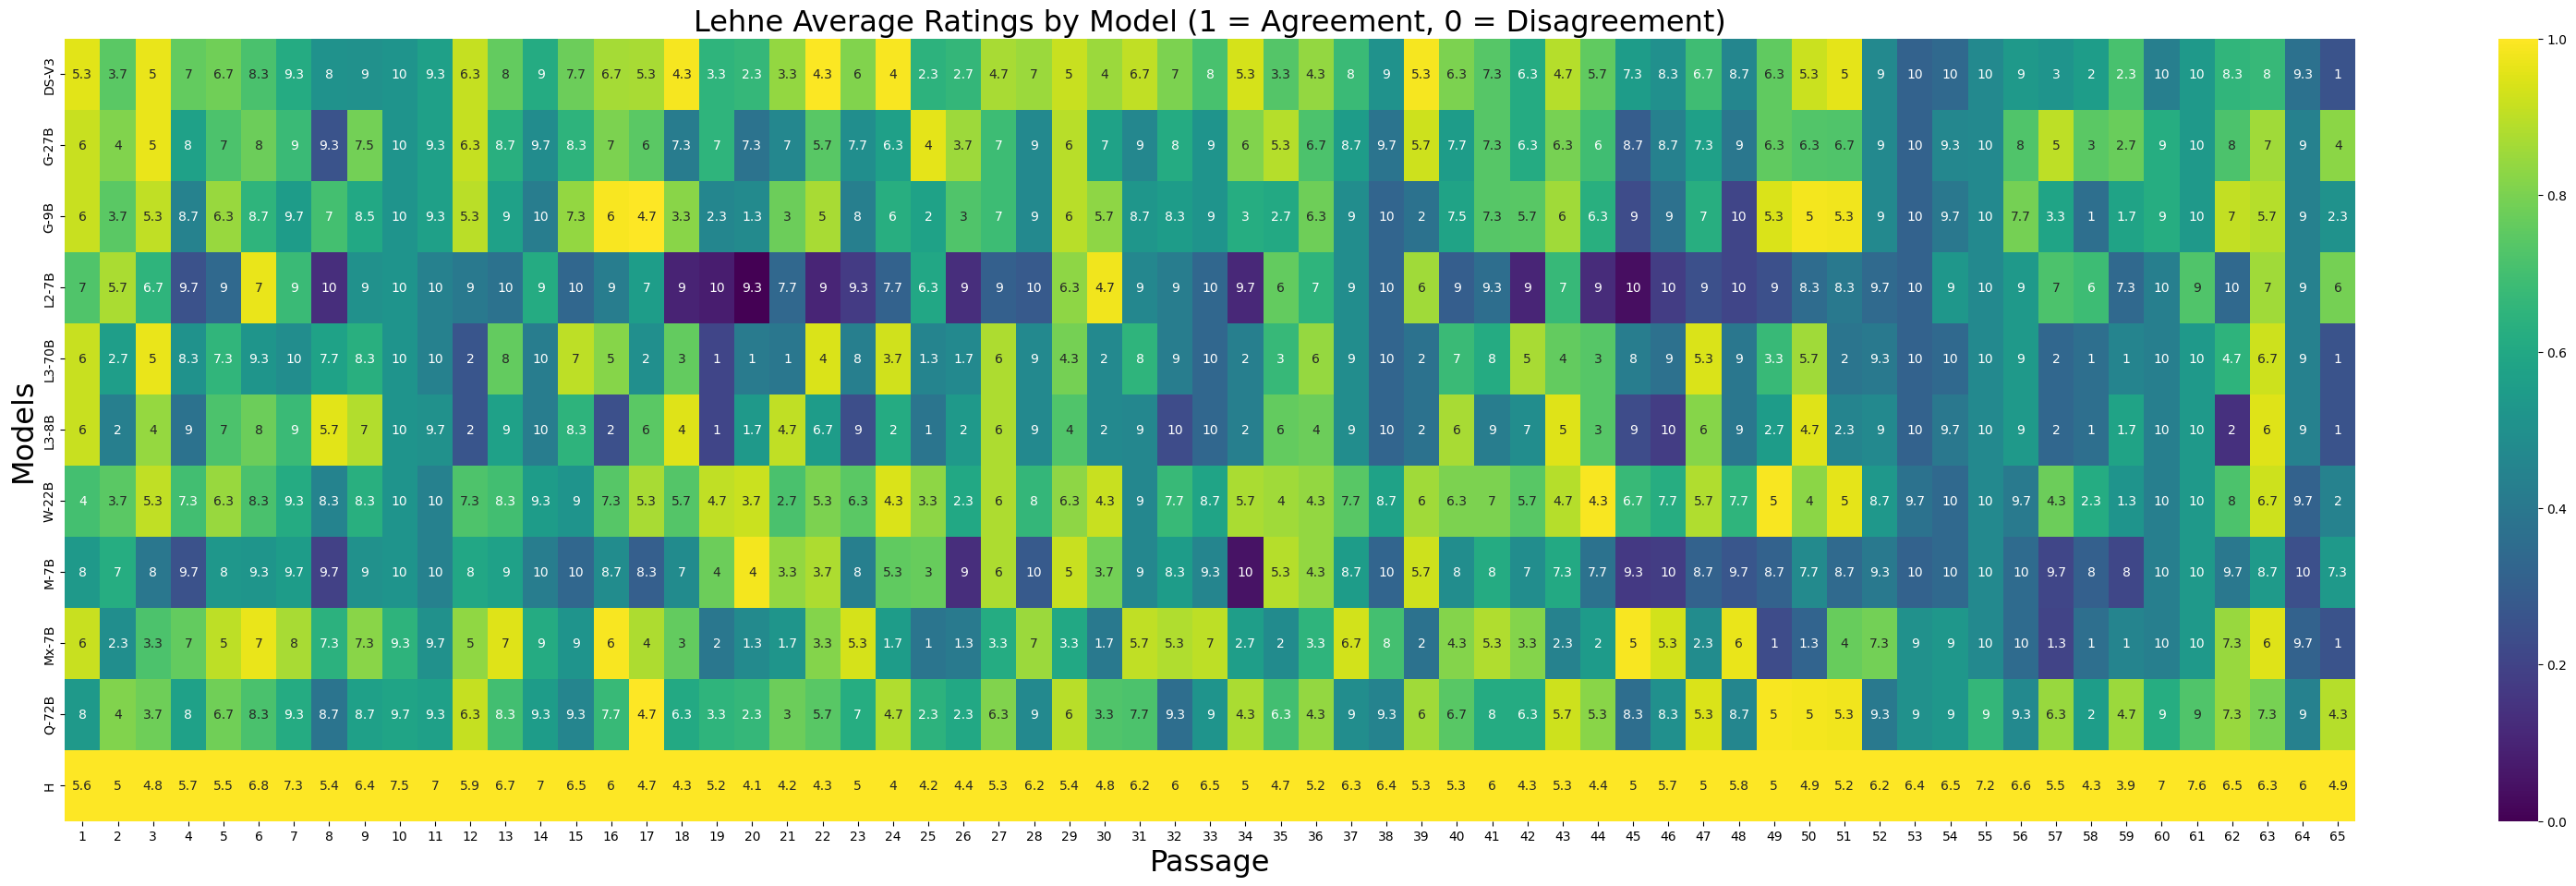

In [101]:
model_names = list(llm_ratings_by_model.keys())
llm_ratings = np.array(list(llm_ratings_by_model.values()) + [human_ratings])

# Compute agreement matrix (1 for agreement, 0 for disagreement)
max_diff = np.max(np.abs(llm_ratings - human_ratings))
agreement_matrix = 1 - (np.abs(llm_ratings - human_ratings) / max_diff)  # Normalize between 0 and 1

# Create a heatmap
plt.figure(figsize=(40, 11))

# Non-Gerrig
ax = sns.heatmap(agreement_matrix, annot=llm_ratings, cmap="viridis", cbar=True, linewidths=0, xticklabels=range(1, llm_ratings.shape[1] + 1), yticklabels=model_names + ["H"])

# Gerrig
# ax = sns.heatmap(agreement_matrix, annot=llm_ratings, cmap="coolwarm_r", cbar=True, linewidths=0.5, xticklabels=["Experiment A,Pen Mentioned Not Removed", "Experiment A,Pen Mentioned Removed", "Experiment A,Pen Not Mentioned", "Experiment B,Unused Comb", "Experiment B,Used Comb", "Experiment C,Prior Solution Mentioned and Removed", "Experiment C,Prior Solution Mentioned Not Removed", "Experiment C,Prior Solution Not Mentioned"], yticklabels=model_names + ["Human"])

plt.title(f"{target} Average Ratings by Model (1 = Agreement, 0 = Disagreement)", fontsize=23)
plt.xlabel("Passage", fontsize=23)
plt.ylabel("Models", fontsize=23)
plt.show()

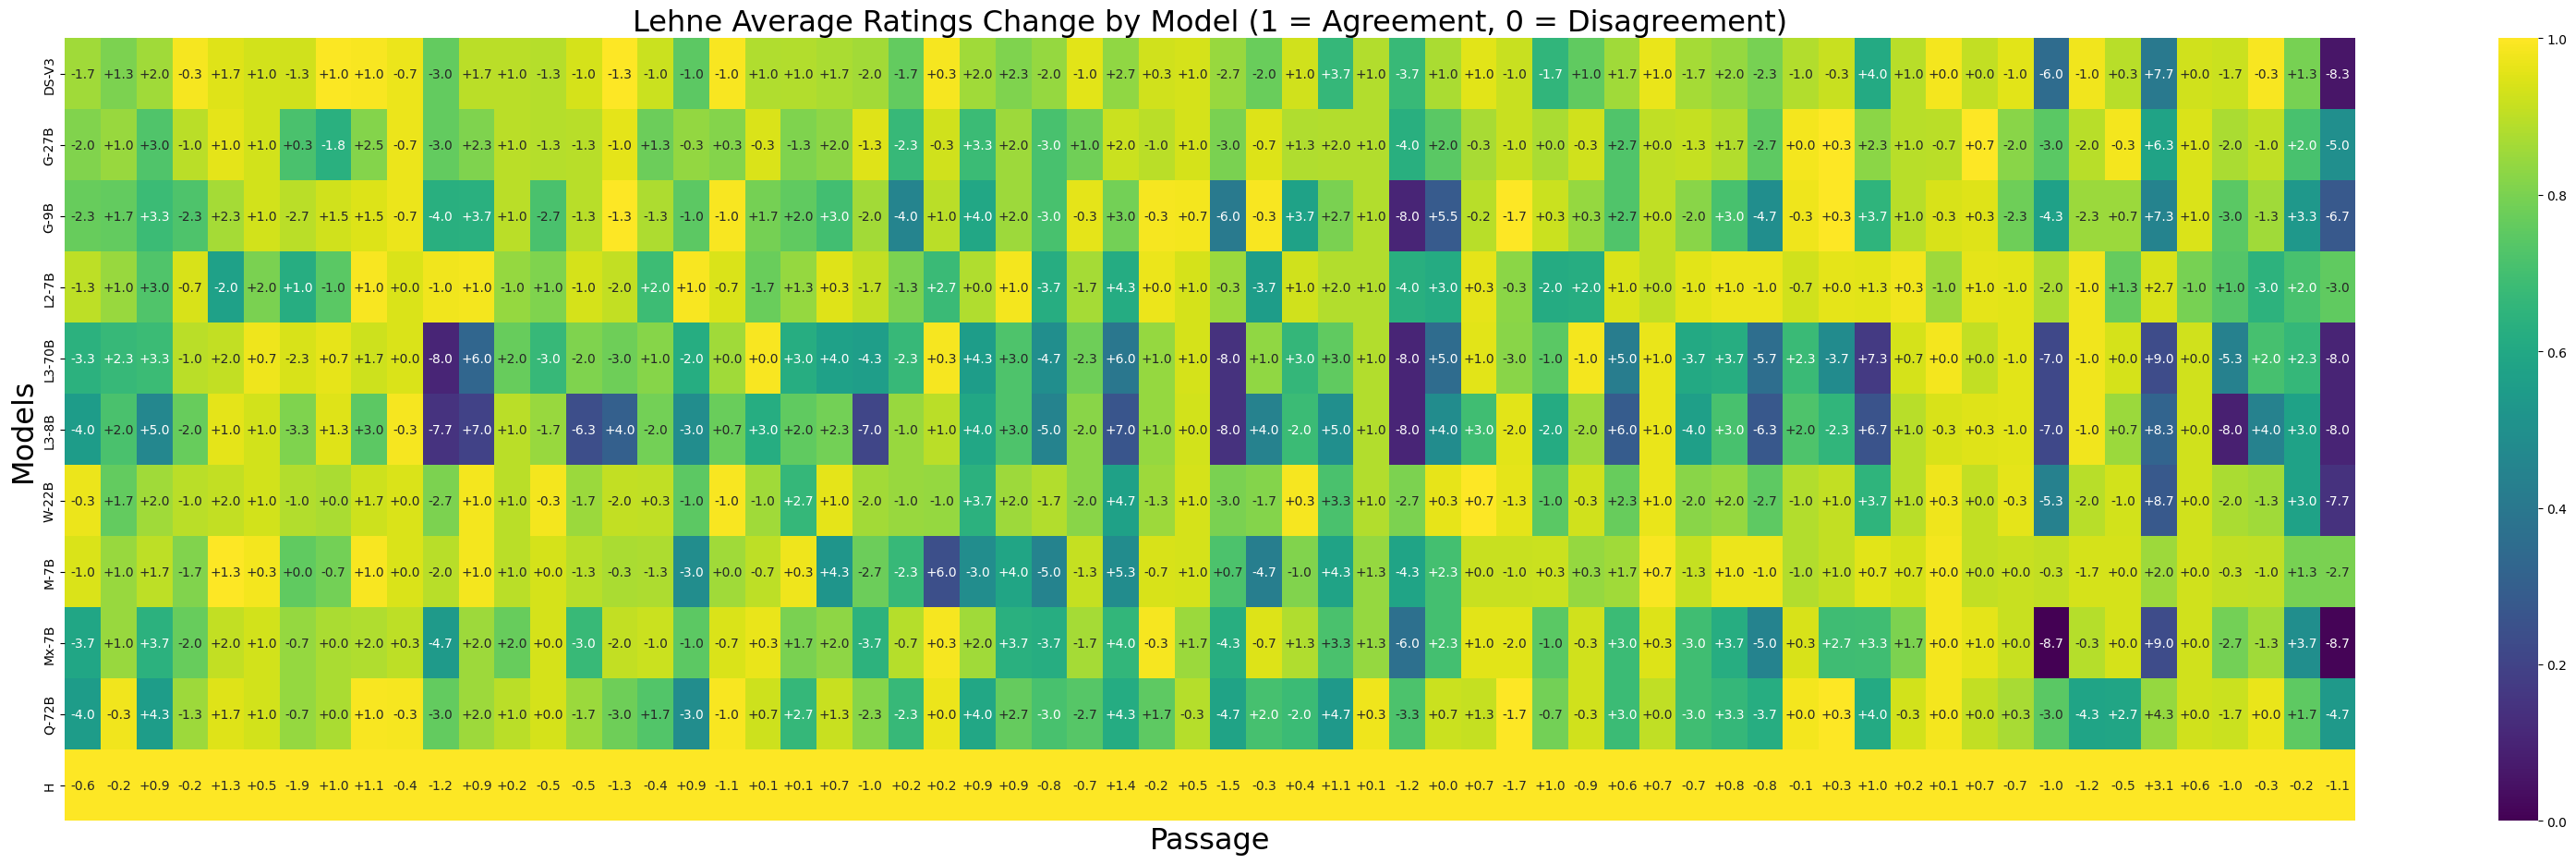

In [95]:
def fmt_func(value):
    return f"+{value:.1f}" if value >= 0 else f"{value:.1f}"

model_names = list(llm_ratings_by_model.keys())
llm_ratings = np.array(list(llm_ratings_by_model.values()) + [human_ratings])

llm_ratings_change = np.diff(llm_ratings)
human_ratings_change = np.diff(human_ratings)

annot_fmt = np.vectorize(fmt_func)(llm_ratings_change)

# Compute agreement matrix (1 for agreement, 0 for disagreement)
max_diff = np.max(np.abs(llm_ratings_change - human_ratings_change))
agreement_matrix = 1 - (np.abs(llm_ratings_change - human_ratings_change) / max_diff)  # Normalize between 0 and 1

# Create a heatmap
plt.figure(figsize=(40, 11))
ax = sns.heatmap(agreement_matrix, annot=annot_fmt, cmap="viridis", cbar=True, linewidths=0.0, xticklabels=range(1, llm_ratings_change.shape[1] + 1), yticklabels=model_names + ["H"], fmt="")

plt.title(f"{target} Average Ratings Change by Model (1 = Agreement, 0 = Disagreement)", fontsize=23)
plt.xlabel("Passage", fontsize=23)
plt.ylabel("Models", fontsize=23)
plt.show()

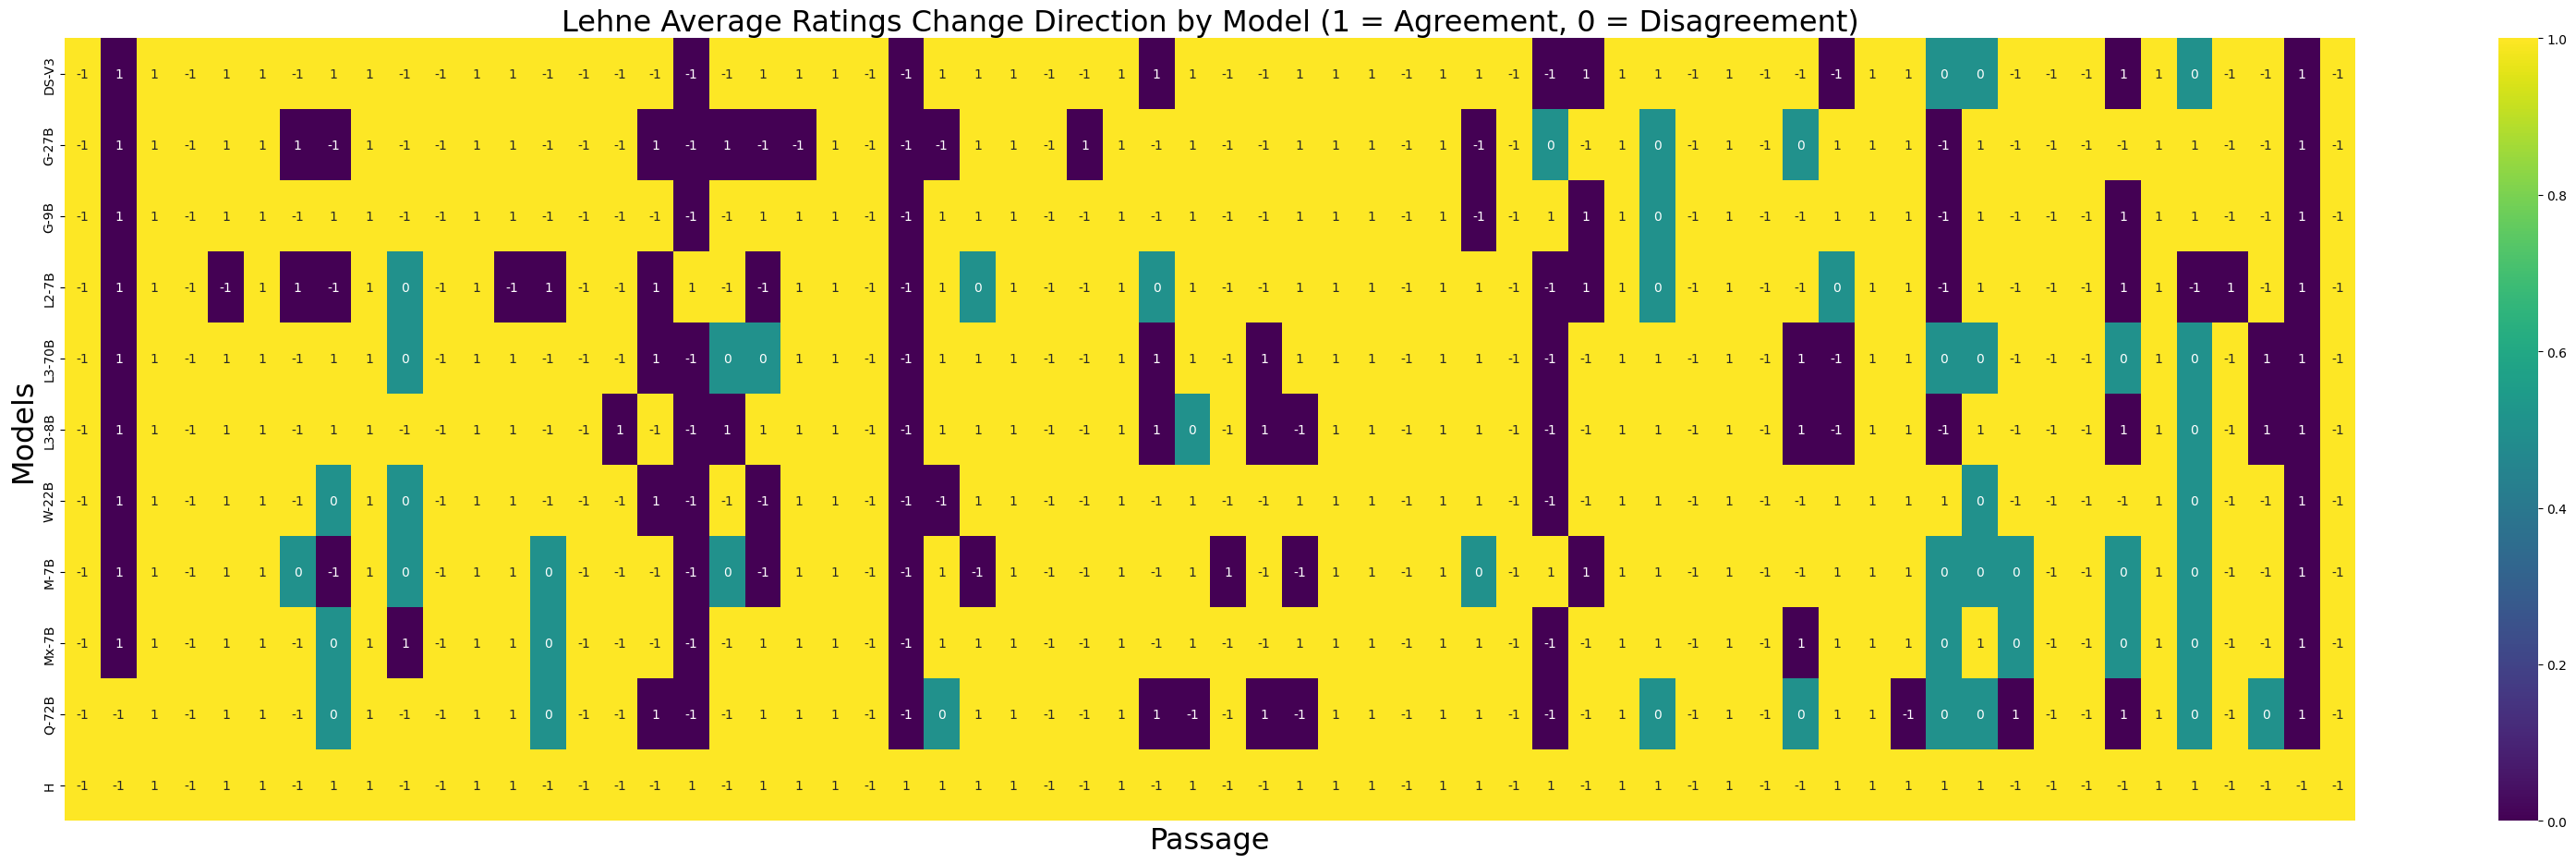

In [96]:
model_names = list(llm_ratings_by_model.keys())
llm_ratings = np.array(list(llm_ratings_by_model.values()) + [human_ratings])

llm_ratings_change = np.diff(llm_ratings)
human_ratings_change = np.diff(human_ratings)

llm_ratings_change_direction = np.where(llm_ratings_change > 0, 1, np.where(llm_ratings_change < 0, -1, llm_ratings_change))
human_ratings_change_direction = np.where(human_ratings_change > 0, 1, np.where(human_ratings_change < 0, -1, human_ratings_change))

# Compute agreement matrix (1 for agreement, 0 for disagreement)
max_diff = np.max(np.abs(llm_ratings_change_direction - human_ratings_change_direction))
agreement_matrix = 1 - (np.abs(llm_ratings_change_direction - human_ratings_change_direction) / max_diff)  # Normalize between 0 and 1

# Create a heatmap
plt.figure(figsize=(40, 11))
ax = sns.heatmap(agreement_matrix, annot=llm_ratings_change_direction, cmap="viridis", cbar=True, linewidths=0.0, xticklabels=range(1, llm_ratings_change_direction.shape[1] + 1), yticklabels=model_names + ["H"])

plt.title(f"{target} Average Ratings Change Direction by Model (1 = Agreement, 0 = Disagreement)", fontsize=23)
plt.xlabel("Passage", fontsize=23)
plt.ylabel("Models", fontsize=23)
plt.show()